# Detect Anything using Grounded SAM

Demo Notebooks
- https://github.com/xinyu1205/recognize-anything/blob/main/recognize_anything_demo.ipynb
- https://github.com/xinyu1205/recognize-anything/blob/main/gui_demo.ipynb

In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda:0")
else:
    print("GPU not available, using the CPU.")
    device = torch.device("cpu")
print(device)

GPU is available!
cuda:0


In [6]:
config_file = "./Grounded-Segment-Anything/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
ram_checkpoint = "./pretrained/ram_swin_large_14m.pth"
tag2text_checkpoint = "./pretrained/tag2text_swin_14m.pth"
grounded_checkpoint = "./Grounded-Segment-Anything/groundingdino_swint_ogc.pth"
sam_checkpoint = "./Grounded-Segment-Anything/sam_vit_h_4b8939.pth"
box_threshold = 0.25
text_threshold = 0.2
iou_threshold = 0.5
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
import os
import random

import cv2
import groundingdino.datasets.transforms as T
import numpy as np
import torch
import torchvision
import torchvision.transforms as TS
from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from PIL import Image, ImageDraw, ImageFont
from ram import inference_ram
from ram import inference_tag2text
from ram.models import ram
from ram.models import tag2text
from segment_anything import SamPredictor, build_sam

In [13]:
def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(
        clean_state_dict(checkpoint["model"]), strict=False)
    print(load_res)
    _ = model.eval()
    return model


def get_grounding_output(model, image, caption, box_threshold, text_threshold, device="cpu"):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    scores = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(
            logit > text_threshold, tokenized, tokenlizer)
        pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        scores.append(logit.max().item())

    return boxes_filt, torch.Tensor(scores), pred_phrases


def draw_mask(mask, draw, random_color=False):
    if random_color:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 153)
    else:
        color = (30, 144, 255, 153)

    nonzero_coords = np.transpose(np.nonzero(mask))

    for coord in nonzero_coords:
        draw.point(coord[::-1], fill=color)


def draw_box(box, draw, label):
    # random color
    color = tuple(np.random.randint(0, 255, size=3).tolist())
    line_width = int(max(4, min(20, 0.006*max(draw.im.size))))
    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=color,  width=line_width)

    if label:
        font_path = os.path.join(
            cv2.__path__[0], 'qt', 'fonts', 'DejaVuSans.ttf')
        font_size = int(max(12, min(60, 0.02*max(draw.im.size))))
        font = ImageFont.truetype(font_path, size=font_size)
        if hasattr(font, "getbbox"):
            bbox = draw.textbbox((box[0], box[1]), str(label), font)
        else:
            w, h = draw.textsize(str(label), font)
            bbox = (box[0], box[1], w + box[0], box[1] + h)
        draw.rectangle(bbox, fill=color)
        draw.text((box[0], box[1]), str(label), fill="white", font=font)

        draw.text((box[0], box[1]), label, font=font)


@torch.no_grad()
def inference(
    raw_image, specified_tags, do_det_seg,
    tagging_model_type, tagging_model, grounding_dino_model, sam_model
):
    print(f"Start processing, image size {raw_image.size}")
    raw_image = raw_image.convert("RGB")

    # run tagging model
    normalize = TS.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = TS.Compose([
        TS.Resize((384, 384)),
        TS.ToTensor(),
        normalize
    ])

    image = raw_image.resize((384, 384))
    image = transform(image).unsqueeze(0).to(device)

    # Currently ", " is better for detecting single tags
    # while ". " is a little worse in some case
    if tagging_model_type == "RAM":
        res = inference_ram(image, tagging_model)
        tags = res[0].strip(' ').replace('  ', ' ').replace(' |', ',')
        print("Tags: ", tags)
    else:
        res = inference_tag2text(image, tagging_model, specified_tags)
        tags = res[0].strip(' ').replace('  ', ' ').replace(' |', ',')
        caption = res[2]
        print(f"Tags: {tags}")
        print(f"Caption: {caption}")

    # return
    if not do_det_seg:
        if tagging_model_type == "RAM":
            return tags.replace(", ", " | "), None
        else:
            return tags.replace(", ", " | "), caption, None

    # run groundingDINO
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    image, _ = transform(raw_image, None)  # 3, h, w

    boxes_filt, scores, pred_phrases = get_grounding_output(
        grounding_dino_model, image, tags, box_threshold, text_threshold, device=device
    )
    print("GroundingDINO finished")

    # run SAM
    image = np.asarray(raw_image)
    sam_model.set_image(image)

    size = raw_image.size
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()
    # use NMS to handle overlapped boxes
    print(f"Before NMS: {boxes_filt.shape[0]} boxes")
    nms_idx = torchvision.ops.nms(boxes_filt, scores, iou_threshold).numpy().tolist()
    boxes_filt = boxes_filt[nms_idx]
    pred_phrases = [pred_phrases[idx] for idx in nms_idx]
    print(f"After NMS: {boxes_filt.shape[0]} boxes")

    transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_filt, image.shape[:2]).to(device)

    masks, _, _ = sam_model.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes.to(device),
        multimask_output=False,
    )
    print("SAM finished")

    # draw output image
    mask_image = Image.new('RGBA', size, color=(0, 0, 0, 0))

    mask_draw = ImageDraw.Draw(mask_image)
    for mask in masks:
        draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)

    image_draw = ImageDraw.Draw(raw_image)

    for box, label in zip(boxes_filt, pred_phrases):
        draw_box(box, image_draw, label)

    out_image = raw_image.convert('RGBA')
    out_image.alpha_composite(mask_image)

    # return
    if tagging_model_type == "RAM":
        return tags.replace(", ", " | "), out_image
    else:
        return tags.replace(", ", " | "), caption, out_image

In [5]:
%%time
# load 4 models

# load RAM
ram_model = ram(pretrained=ram_checkpoint, image_size=384, vit='swin_l')
ram_model.eval()
ram_model = ram_model.to(device)

# load Tag2Text
delete_tag_index = []  # filter out attributes and action categories which are difficult to grounding
for i in range(3012, 3429):
    delete_tag_index.append(i)

tag2text_model = tag2text(pretrained=tag2text_checkpoint,
                                    image_size=384,
                                    vit='swin_b',
                                    delete_tag_index=delete_tag_index)
tag2text_model.threshold = 0.64  # we reduce the threshold to obtain more tags
tag2text_model.eval()
tag2text_model = tag2text_model.to(device)

# load groundingDINO
grounding_dino_model = load_model(config_file, grounded_checkpoint, device=device)

# load SAM
sam_model = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
./pretrained/ram_swin_large_14m.pth
--------------
load checkpoint from ./pretrained/ram_swin_large_14m.pth
vit: swin_l
/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


-----
RAM:
Start processing, image size (3000, 2155)
Tags:  armchair, blanket, lamp, carpet, couch, dog, floor, furniture, gray, green, living room, picture frame, pillow, plant, room, sit, stool, wood floor
GroundingDINO finished
Before NMS: 23 boxes
After NMS: 18 boxes
SAM finished


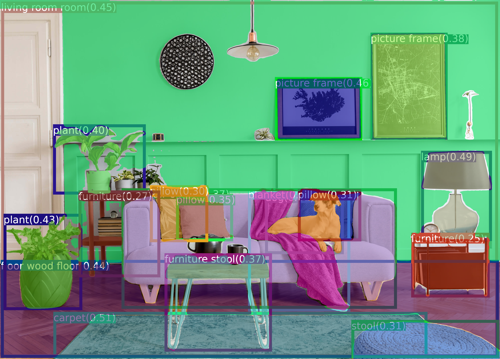

CPU times: user 4.55 s, sys: 52.9 ms, total: 4.61 s
Wall time: 4.67 s


In [19]:
%%time
# let's try with an image
def inference_with_ram(img, do_det_seg):
    return inference(img, None, do_det_seg, "RAM", ram_model, grounding_dino_model, sam_model)

def inference_with_t2t(img, input_tags, do_det_seg):
    return inference(img, input_tags, do_det_seg, "Tag2Text", tag2text_model, grounding_dino_model, sam_model)

in_img = Image.open("Grounded-Segment-Anything/assets/demo9.jpg")

print("-----\nRAM:")
ram_tags, ram_out_image = inference_with_ram(in_img, do_det_seg=True)
ram_out_image.thumbnail((500, 500))
display(ram_out_image.convert('RGB'))

# print("-----\nTag2Text:")
# t2t_tags, t2t_caption, t2t_out_image = inference_with_t2t(in_img, input_tags="", do_det_seg=True)
# t2t_out_image.thumbnail((500, 500))
# display(t2t_out_image)